In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

In [1]:
PROCESSED_DIR = "data/processed"

In [3]:
patients_to_use = pd.read_csv("data/processed/AL_for_ccp_02.tsv", sep="\t", index_col=0).index
vars_to_use = a.rename(columns=amyloid.ddict_unclean).columns

print("* {} patients".format(patients_to_use.shape[0]))
print("* {} variables".format(vars_to_use.shape[0]))

* 2074 patients
* 28 variables


In [4]:
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep="\t", index_col=0).rename(columns=amyloid.ddict_unclean).loc[patients_to_use,:]

In [16]:
# Dataframes
X = data_df.loc[:,vars_to_use]
Xi_mice = pd.read_csv("data/imputed/mice_qvars_05.tsv", sep="\t", index_col=0)

### 1. Initialize PCA
---

<Axes: xlabel='PC 2 (10.15%)', ylabel='PC 1 (11.17%)'>

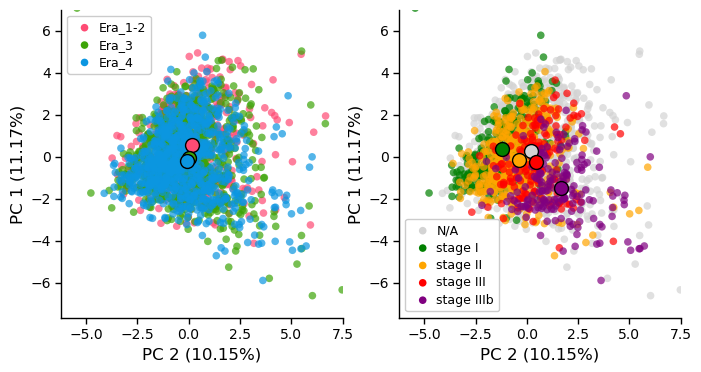

In [29]:
# Using MICE imputed
P_df, pca, pca_vars = utils.get_pcs(Xi_mice)

alpha=0.7
xlim=(None,7.5)
ylim=(None,7)

fig,axes = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Era"], 
                 ax=axes[0], 
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].fillna("N/A"), 
                 ax=axes[1], 
                 cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )

In [135]:
meta_df = pd.read_csv("data/processed/AL_with_ccp_03.tsv",sep="\t",index_col=0)[["cluster","cluster4"]].dropna()
meta_df = meta_df.rename(columns={"cluster":"ccp_3", "cluster4":"ccp_4"})

### 2. Try
---

In [136]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

In [137]:
# Silhoutte Score: mean nearest-cluster distance - mean intra-cluster distance / max of two
# Davies-Bouldin Index: average similarity measure of each cluster with its most similar cluster. Similarity is the ratio of within-cluster distances to between-cluster distances.
# Calinski-Harabasz (C-H) Index (or variance ratio criterion): ratio between within-cluster dispersion and between cluster dispersion

In [138]:
Xi_mice_scale = StandardScaler().fit_transform(Xi_mice)

In [152]:
# K-means
n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n in n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n, n_init="auto", random_state=10)
    meta_df["kmeans_{}".format(n)] = clusterer.fit_predict(Xi_mice_scale)

    # Heirarchical clustering
    clusterer = AgglomerativeClustering(n_clusters=n, metric="cosine", linkage="complete").fit(Xi_mice_scale)
    meta_df["agg_{}".format(n)] = clusterer.fit_predict(Xi_mice_scale)

    # Heirarchical clustering
    clusterer = AgglomerativeClustering(n_clusters=n).fit(Xi_mice_scale)
    meta_df["agg_euc_{}".format(n)] = clusterer.fit_predict(Xi_mice_scale)

<Axes: xlabel='PC 2 (10.15%)', ylabel='PC 1 (11.17%)'>

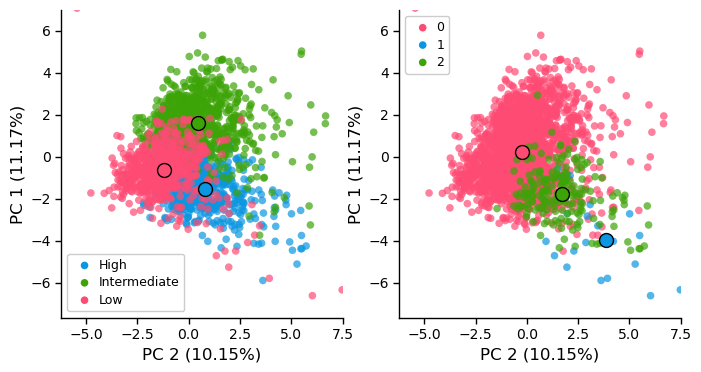

In [157]:
fig,axes = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, cohort_s=meta_df.loc[P_df.index, "ccp_3"], 
                 ax=axes[0], 
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )


plot.plot_pca_ax(P_df, pca, cohort_s=meta_df.loc[P_df.index, "agg_euc_3"], 
                 ax=axes[1], 
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )


In [154]:
def compute_clustering_metrics(meta_df, X):
    """_summary_

    Args:
        meta_df (_type_): _description_
        X (_type_): _description_
    """
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

    result = {}

    for c in meta_df.columns:
        _result = {}

        # Silhouette Score
        _result["silhouette_cosine"] = silhouette_score(X, meta_df[c], metric="cosine")
        _result["silhouette_euclidean"] = silhouette_score(X, meta_df[c])
        _result["davies_bouldin"] = davies_bouldin_score(X, meta_df[c])
        _result["ch"] = calinski_harabasz_score(X, meta_df[c])

        result[c] = _result
    
    return pd.DataFrame.from_dict(result).T

df = compute_clustering_metrics(meta_df, Xi_mice_scale)

In [163]:
from scipy.stats import spearmanr

,Kappa-sFLC,Lambda-sFLC,kappa:lambda ratio,dFLC,Bone marrow plasma cells (%),IVSd,LVEF,WBC,Hemoglobin,MCV,...,BNP,Troponin,Calcium,Uric acid,LDH,Iron,TIBC,Systolic BP sitting,Diastolic BP sitting,Pulse sitting
Code ID,,,,,,,,,,,,,,,,,,,,,
2004061,26.9,32.1,0.84,5.2,5.0,10.0,60.0,3.6,12.5,98.0,...,145.0,0.006,7.5,6.6,319.0,47.0,234.0,130.0,86.0,76.0
2018115,10.0,249.7,0.04,239.7,30.0,16.0,42.0,7.3,14.4,94.0,...,818.0,0.038,9.9,12.5,217.0,93.0,336.0,115.0,82.0,74.0
2018116,68.3,2271.4,0.03,2203.1,30.0,19.0,63.0,5.1,11.0,89.0,...,186.0,0.059,9.9,13.7,164.0,37.0,271.0,119.0,76.0,85.0
2018117,360.9,14.2,25.42,346.7,15.0,9.0,60.0,14.4,13.4,97.0,...,798.0,0.069,9.0,7.9,323.0,74.0,259.0,129.0,68.0,60.0
2018122,90.6,6.3,14.38,84.3,20.0,15.0,59.0,8.0,13.7,85.0,...,503.0,0.098,9.6,11.8,213.0,61.0,268.0,126.0,82.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022080,66.6,13.6,4.90,53.0,20.0,12.0,60.0,5.5,12.0,97.0,...,83.0,0.006,9.1,8.3,210.0,143.0,325.0,168.0,94.0,52.0
2022088,213.6,17.2,12.42,196.4,15.0,11.0,63.0,10.8,12.2,95.0,...,106.0,0.056,8.5,7.0,326.0,61.0,217.0,155.0,83.0,78.0
2022102,24.1,95.4,0.25,71.3,10.0,9.0,65.0,5.0,14.2,88.0,...,23.0,0.006,9.9,5.7,406.0,80.0,301.0,142.0,79.0,65.0


In [171]:
spearmanr?

Signature:
spearmanr(
    a,
    b=None,
    axis=0,
    nan_policy='propagate',
    alternative='two-sided',
)
Docstring:
Calculate a Spearman correlation coefficient with associated p-value.

The Spearman rank-order correlation coefficient is a nonparametric measure
of the monotonicity of the relationship between two datasets.
Like other correlation coefficients,
this one varies between -1 and +1 with 0 implying no correlation.
Correlations of -1 or +1 imply an exact monotonic relationship. Positive
correlations imply that as x increases, so does y. Negative correlations
imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system
producing datasets that have a Spearman correlation at least as extreme
as the one computed from these datasets. Although calculation of the
p-value does not make strong assumptions about the distributions underlying
the samples, it is only accurate for very large samples (>500
observations). For smaller s

In [199]:
%%time
corr_X = spearmanr(Xv[:100,].T, nan_policy='omit')

CPU times: user 5.01 s, sys: 59.7 ms, total: 5.07 s
Wall time: 5.17 s


In [198]:
spearmanr?

Signature:
spearmanr(
    a,
    b=None,
    axis=0,
    nan_policy='propagate',
    alternative='two-sided',
)
Docstring:
Calculate a Spearman correlation coefficient with associated p-value.

The Spearman rank-order correlation coefficient is a nonparametric measure
of the monotonicity of the relationship between two datasets.
Like other correlation coefficients,
this one varies between -1 and +1 with 0 implying no correlation.
Correlations of -1 or +1 imply an exact monotonic relationship. Positive
correlations imply that as x increases, so does y. Negative correlations
imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system
producing datasets that have a Spearman correlation at least as extreme
as the one computed from these datasets. Although calculation of the
p-value does not make strong assumptions about the distributions underlying
the samples, it is only accurate for very large samples (>500
observations). For smaller s

In [190]:
a.correlation



array([[1.        , 0.47964826, 0.87857143, ..., 0.51071429, 0.85054945,
        0.55604396],
       [0.47964826, 1.        , 0.58614358, ..., 0.9270388 , 0.51992652,
        0.90507751],
       [0.87857143, 0.58614358, 1.        , ..., 0.64293086, 0.89460784,
        0.61764706],
       ...,
       [0.51071429, 0.9270388 , 0.64293086, ..., 1.        , 0.54656863,
        0.91666667],
       [0.85054945, 0.51992652, 0.89460784, ..., 0.54656863, 1.        ,
        0.52647059],
       [0.55604396, 0.90507751, 0.61764706, ..., 0.91666667, 0.52647059,
        1.        ]])

In [174]:
X.dropna()

,Kappa-sFLC,Lambda-sFLC,kappa:lambda ratio,dFLC,Bone marrow plasma cells (%),IVSd,LVEF,WBC,Hemoglobin,MCV,...,BNP,Troponin,Calcium,Uric acid,LDH,Iron,TIBC,Systolic BP sitting,Diastolic BP sitting,Pulse sitting
Code ID,,,,,,,,,,,,,,,,,,,,,
2004061,26.9,32.1,0.84,5.2,5.0,10.0,60.0,3.6,12.5,98.0,...,145.0,0.006,7.5,6.6,319.0,47.0,234.0,130.0,86.0,76.0
2018115,10.0,249.7,0.04,239.7,30.0,16.0,42.0,7.3,14.4,94.0,...,818.0,0.038,9.9,12.5,217.0,93.0,336.0,115.0,82.0,74.0
2018116,68.3,2271.4,0.03,2203.1,30.0,19.0,63.0,5.1,11.0,89.0,...,186.0,0.059,9.9,13.7,164.0,37.0,271.0,119.0,76.0,85.0
2018117,360.9,14.2,25.42,346.7,15.0,9.0,60.0,14.4,13.4,97.0,...,798.0,0.069,9.0,7.9,323.0,74.0,259.0,129.0,68.0,60.0
2018122,90.6,6.3,14.38,84.3,20.0,15.0,59.0,8.0,13.7,85.0,...,503.0,0.098,9.6,11.8,213.0,61.0,268.0,126.0,82.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022080,66.6,13.6,4.90,53.0,20.0,12.0,60.0,5.5,12.0,97.0,...,83.0,0.006,9.1,8.3,210.0,143.0,325.0,168.0,94.0,52.0
2022088,213.6,17.2,12.42,196.4,15.0,11.0,63.0,10.8,12.2,95.0,...,106.0,0.056,8.5,7.0,326.0,61.0,217.0,155.0,83.0,78.0
2022102,24.1,95.4,0.25,71.3,10.0,9.0,65.0,5.0,14.2,88.0,...,23.0,0.006,9.9,5.7,406.0,80.0,301.0,142.0,79.0,65.0


In [155]:
from sklearn.cluster import AgglomerativeClustering

data_matrix = [[0,0.8,0.9],[0.8,0,0.2],[0.9,0.2,0]]
model = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='complete').fit(data_matrix)
print(model.labels_)

,silhouette_cosine,silhouette_euclidean,davies_bouldin,ch
agg_8,0.017782,-0.048510,4.030053,45.564698
agg_7,0.021868,-0.042803,4.034986,51.123317
agg_4,0.032324,-0.030348,4.023774,62.011773
agg_6,0.018390,-0.029685,3.994432,52.342238
agg_5,0.030796,-0.025181,3.924959,56.172848
ccp_4,0.094668,0.023919,4.851352,83.710116
agg_2,0.093566,0.027275,4.089266,78.235827
agg_3,0.071641,0.031752,4.552325,74.653968
agg_euc_6,0.036785,0.032080,2.487111,93.409057
agg_euc_7,0.002900,0.034167,2.137387,90.385674
